# Quick Overview of RLFH

The performance of Language Models until GPT-3 was kind of amazing as-is. What the models of were essentially lacking was the aspect of **alignment**. The language generation aspect was particularly challenging due to heavy hallucinations, toxicity, etc.

The authors of the seminal work **[InstructGPT](https://arxiv.org/pdf/2203.02155)** basically focussed on this aspect of aligning the language models to user's intructions (hence the name!). Their work showcased how we can further fine-tune such models in a supervised way leverage human feedback and reinforcement learning to align them.

## High-Level Overview of the Setup

<img src="./assets/instruct_gpt_rlhf.png">

> Source: https://arxiv.org/pdf/2203.02155

## Key Concepts:

- **Reinforcement Learning (RL)**: A machine learning paradigm where an agent learns to make decisions by performing actions and receiving _rewards or penalties_ .
- **Human Feedback**: Evaluations provided by humans that guide the learning process, ensuring the model's outputs align with human expectations and preferences.

## How Does this Actually Work? Show Me Examples Please?

### Standard Supervised Learning:
- Input: "Generate a story about a dragon and a knight."
- Output: The model generates a story based on its training data.


### Reinforcement Learning From Human Feedback:
- Input: "Generate a story about a dragon and a knight."
- Initial Output: The model generates a story.
- Human Feedback: A human rates the story on coherence, creativity, and engagement.
- Adjusted Output: The model refines its story generation based on the feedback, leading to more engaging and coherent stories over time.

As pointed out in the figure above, one of the ways of bringing this alignment is through:
- Training a **reward model** using a Human labelled dataset.
    - This dataset basically contains rank ordered responses to different inputs to the model
- The reward model learns to predict human preferences based on the provided human feedback by assigning a score (reward) to the outputs of the language model.
-  The output of the reward model is then used to update the policy of the language model (agent) to align with the human feedback (exploration vs exploitation)


<img src="https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/trl_overview.png">

> Source: https://huggingface.co/docs/trl/en/quickstart

## PPO vs DPO

There are different ways of performing policy optimisation. The original work follows Proximal Policy Optimisation which requires a separate reward model to tune the Language Model. DPO or Direct Policy Optimisation directly applies updates to the language model thus removing the need for a separate reward model.

> Read more about RL and KL Divergence to understand the topic better


> The KL-divergence between the two outputs is used as an _additional reward signal_ to make sure the generated responses don’t deviate too far from the reference language model.

# Quick Hello World Using PPO

> Can we improve alignment of Phi-1.5?

> Adapted from:
> [[1](https://huggingface.co/docs/trl/en/quickstart)], [[2](https://github.com/antndlcrx/oxford-llms-workshop/blob/main/materials/seminars/day_3/8_LLMs%20alignment%20with%20RLHF.ipynb)]

## Install Dependencies

In [1]:
!pip install transformers trl datasets accelerate matplotlib  tensorboard tensorboardx seaborn


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


## Import Packages

In [2]:
import random
import torch
import time
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
import numpy as np

tqdm.pandas()

from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, pipeline
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from trl.core import LengthSampler

## Configs

In [3]:
text_input_length = 5
text_output_length = 20
seed = 42

sentiment_pipe_kwargs = {
    "top_k": None, 
    "function_to_apply": "none",
    'return_all_scores':False
}
# microsoft/Phi-3-mini-4k-instruct
ppo_config = PPOConfig(
    model_name="microsoft/phi-2", 
    steps=200,
    learning_rate=1.41e-5, 
    remove_unused_columns=False,
    log_with="tensorboard",
    project_kwargs={"logging_dir": "./logs"},
)

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    #"max_new_tokens": text_output_length,
    #"eos_token_id": -1,
}

ALIGNED_MODEL_NAME = f"aligned-{ppo_config.model_name.split('/')[1]}"

In [4]:
from huggingface_hub import notebook_login

notebook_login()

## Download Models

In [6]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(ppo_config.model_name,cache_dir="/workspace/")
# create a reference model
ref_model = create_reference_model(model, num_shared_layers=6)
tokenizer = AutoTokenizer.from_pretrained(ppo_config.model_name,cache_dir="/workspace/")

tokenizer.pad_token = tokenizer.eos_token
generation_kwargs["pad_token_id"] = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
!nvidia-smi

## Prepare Dataset

In [7]:
def prepare_dataset(
    tokenizer, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8
):
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [8]:
dataset = prepare_dataset(tokenizer)


def data_collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

## Setup PPO Trainer

In [9]:
ppo_trainer = PPOTrainer(ppo_config,
                         model,
                         ref_model,
                         tokenizer,
                         dataset,
                         data_collator=data_collator,
                         )

In [10]:
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  
else:
    device = ppo_trainer.accelerator.device
print(f"Accelerator Device={device}")

Accelerator Device=0


In [11]:
ppo_trainer.accelerator.device

device(type='cuda')

### Setup Reward Model and Utils

### Reward Assignment

The objective is to align our text generation model towards the alignment signal provided.
To do so, we need to assign a corresponding reward to each output logit

In [12]:
## Get the Reward Model
distilbert_tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb",eos_token='</s>')
sentiment_pipe = pipeline("sentiment-analysis", "lvwerra/distilbert-imdb", tokenizer=distilbert_tokenizer,device=device)

# test out the pipeline
text = "this movie was really bad!!"
output = sentiment_pipe(text, **sentiment_pipe_kwargs)
output

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


[{'label': 'NEGATIVE', 'score': 2.3350484371185303},
 {'label': 'POSITIVE', 'score': -2.726576328277588}]

## Time to Align using RLHF : PPO
> Todo add steps overview

In [13]:
from tqdm.notebook import tqdm

In [15]:
output_min_length = 10
output_max_length = 25
num_steps = 5
overall_rewards = list()
output_length_sampler = LengthSampler(output_min_length, output_max_length)

In [16]:
generation_kwargs["pad_token_id"]= tokenizer.eos_token_id

In [17]:
for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    if epoch >= num_steps:
        break

    query_tensors = batch["input_ids"]

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sentiment_pipe_kwargs)
    rewards = list()
    for output in pipe_outputs:
        if output[0]['score']>output[1]['score']:
            if output[0]['label'] == 'POSITIVE':
                rewards.append(torch.tensor(4*output[0]['score']))
            else:
                rewards.append(torch.tensor(0.5*output[0]['score']))
        elif output[1]['score']>output[0]['score']:
            if output[1]['label'] == 'POSITIVE':
                rewards.append(torch.tensor(4*output[1]['score']))
            else:
                rewards.append(torch.tensor(0.25*output[0]['score']))

    overall_rewards.append(rewards)
    #PPO step
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print("-".join("" for x in range(100)))

    ppo_trainer.log_stats(stats, batch, rewards)

0it [00:00, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


objective/kl: 0.0
ppo/returns/mean: 2.329904317855835
ppo/policy/advantages_mean: -3.260224445966742e-08
---------------------------------------------------------------------------------------------------
objective/kl: 1.0848491191864014
ppo/returns/mean: 3.011728286743164
ppo/policy/advantages_mean: -9.811463641540286e-09
---------------------------------------------------------------------------------------------------
objective/kl: 1.9583141803741455
ppo/returns/mean: 3.3636350631713867
ppo/policy/advantages_mean: -1.5503298200769677e-08
---------------------------------------------------------------------------------------------------
objective/kl: 2.7539970874786377
ppo/returns/mean: 3.6526408195495605
ppo/policy/advantages_mean: 2.8892639392097408e-08
---------------------------------------------------------------------------------------------------
objective/kl: 4.090468883514404
ppo/returns/mean: 4.382137298583984
ppo/policy/advantages_mean: -3.667978276666872e-08
-------------

### Plot Reward Distribution

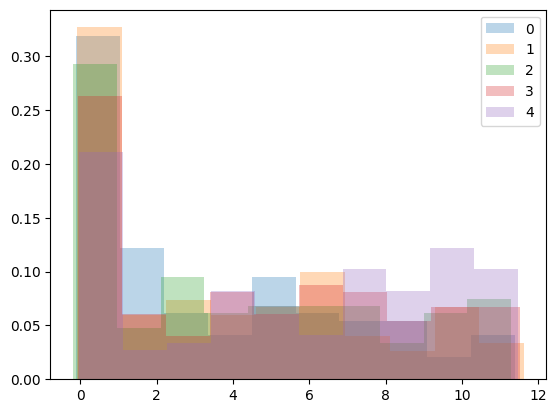

In [18]:
for idx,epoch_rewards in enumerate(overall_rewards):
    plt.hist([i.item() for i in epoch_rewards], density=True, alpha=0.3)
plt.legend(range(10))
plt.show()

### Compare Rewards

In [20]:
bs = 16
game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

#### get response from phi2 and phi2_ref
for i in range(bs):
    gen_len = output_length_sampler()
    output = ref_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
        # max_new_tokens=gen_len,
        **generation_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    output = model.generate(
        input_ids=torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
        # max_new_tokens=gen_len,
        **generation_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

#### decode responses
game_data["response (before)"] = [
    tokenizer.decode(response_tensors_ref[i]) for i in range(bs)
]
game_data["response (after)"] = [
    tokenizer.decode(response_tensors[i]) for i in range(bs)
]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
# game_data["rewards (before)"] = [
#     output[1]["score"] for output in sentiment_pipe(texts, **sentiment_pipe_kwargs)
# ]
game_data["rewards (before)"]=list()
for output in sentiment_pipe(texts, **sentiment_pipe_kwargs):
        if output[0]['score']>output[1]['score']:
            if output[0]['label'] == 'POSITIVE':
                game_data["rewards (before)"].append(4*output[0]['score'])
            else:
                game_data["rewards (before)"].append(0.5*output[0]['score'])
        elif output[1]['score']>output[0]['score']:
            if output[1]['label'] == 'POSITIVE':
                game_data["rewards (before)"].append(t4*output[1]['score'])
            else:
                game_data["rewards (before)"].append(0.25*output[0]['score'])

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
# game_data["rewards (after)"] = [
#     output[1]["score"] for output in sentiment_pipe(texts, **sentiment_pipe_kwargs)
# ]
game_data["rewards (after)"]=list()
for output in sentiment_pipe(texts, **sentiment_pipe_kwargs):
        if output[0]['score']>output[1]['score']:
            if output[0]['label'] == 'POSITIVE':
                game_data["rewards (after)"].append(4*output[0]['score'])
            else:
                game_data["rewards (after)"].append(0.5*output[0]['score'])
        elif output[1]['score']>output[0]['score']:
            if output[1]['label'] == 'POSITIVE':
                game_data["rewards (after)"].append(4*output[1]['score'])
            else:
                game_data["rewards (after)"].append(0.25*output[0]['score'])


# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,This really,there is no more cliché or grand statement fr...,"is passion and a love of the craft, and you",0.084087,10.838050
1,This film,blowing experience. It will change you and lea...,"""The Football Manager"". It is set in the Ghan...",8.913700,3.289817
2,When i,and get it to print letters i get 1.\nDon't u...,"the result, it's give me the output tiger. bu...",0.550711,0.451357
3,The only aspect of this film that,such as those scenes of typical Hollywood sex...,"brothers' musical talents, which is always ve...",0.989781,9.614667
4,THE SC,"The Art of Skinning, Sutton delves into philo...",ETradsheinshowbacktheartshowproductshows,5.689440,0.192083
5,Bette Midler is again,ing a cast entirely of Los Angeles actors in h...,"star and photographer Nicholas Will, helping ...",5.354937,10.702723
6,"Firstly, this is simply the",". But more significantly, COVID-19 has left li...","The word comes from two Latin words, for they...",0.529174,4.980739
7,Or at least one of,this approach was not sustainable. I would of...,"in their face. Above all, we must try not to",0.691320,0.421196
8,I read in the papers that,sociology papers you have to look at somethin...,"have been going on anyway, and you've been wo...",0.225386,0.488963
9,Don't get me wrong,", it is a case of the wild boar the size of a ...",", I still love playing PC games and watching m...",0.050499,4.174393


### Save Aligned Model Objects

In [21]:
model.save_pretrained(ALIGNED_MODEL_NAME)
tokenizer.save_pretrained(ALIGNED_MODEL_NAME)

('aligned-phi-2/tokenizer_config.json',
 'aligned-phi-2/special_tokens_map.json',
 'aligned-phi-2/vocab.json',
 'aligned-phi-2/merges.txt',
 'aligned-phi-2/added_tokens.json',
 'aligned-phi-2/tokenizer.json')

In [27]:
# uncomment if you would like to push to HF Hub
# model.push_to_hub(ALIGNED_MODEL_NAME,commit_message="PPO alignment done")
# tokenizer.push_to_hub(ALIGNED_MODEL_NAME,commit_message="PPO alignment done")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/raghavbali/aligned-phi-2/commit/4e5eb398531c419a377d6f0ae6bd75ffbeaab0c7', commit_message='PPO alignment done', commit_description='', oid='4e5eb398531c419a377d6f0ae6bd75ffbeaab0c7', pr_url=None, pr_revision=None, pr_num=None)

## Generate and Compare Aligned vs Non-Aligned Models

In [22]:
from IPython.display import display, Markdown

In [28]:
# double checking if we are still refering to same model
ALIGNED_MODEL_NAME

'aligned-phi-2'

In [30]:
hub_model = AutoModelForCausalLMWithValueHead.from_pretrained(f'raghavbali/{ALIGNED_MODEL_NAME}',
                                                              cache_dir="/workspace/")
# create a reference model
hub_tokenizer = AutoTokenizer.from_pretrained(f'raghavbali/{ALIGNED_MODEL_NAME}',
                                              cache_dir="/workspace/")

hub_tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at raghavbali/aligned-phi-2 were not used when initializing PhiForCausalLM: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing PhiForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PhiForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.41k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

In [31]:
reviews = [
    "If I have to review this movie, I would",
    "The actors in this movie",
    "The makers of this movie",
    "I went to this movie for",
    "The thing about this movie",
    "Here are my 2 cents on the movie",
    
]

In [36]:
for review in reviews:
    inputs = hub_tokenizer(review, return_tensors="pt", return_token_type_ids=False).to(device)
    print("----ALIGNED-MODEL ----")
    outputs = hub_model.generate(**inputs,max_new_tokens=25,temperature=0.8,do_sample=True)
    display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
    print("---- NON-ALIGNEDD-MODEL ----")
    outputs = ref_model.generate(**inputs, max_new_tokens=25,temperature=0.8,do_sample=True)
    display(Markdown((tokenizer.decode(outputs[0], skip_special_tokens=True))))
    print("---- END ----")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


----ALIGNED-MODEL ----


If I have to review this movie, I would say the best part of this movie is how beautiful it is and how well it shows the lives of the people of the time

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


If I have to review this movie, I would give it 3 stars. It had some funny moments and a good storyline, but there were also some parts that felt a bit

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- END ----
----ALIGNED-MODEL ----


The actors in this movie are amazing! They bring their characters to life and make us feel like we are a part of the story. We can feel

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


The actors in this movie were very talented. They made us feel like we were right there in the park, watching all the exciting things that were happening

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- END ----
----ALIGNED-MODEL ----


The makers of this movie have done a great job in bringing the story of the American Revolution to life. We can learn a lot about this important time

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


The makers of this movie are from a place called Kerala, which is in India. The movie is in a language called Malayalam, which they

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- END ----
----ALIGNED-MODEL ----


I went to this movie for the first time and it left a deep impression on me".

Plot

The film is narrated by a young boy

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


I went to this movie for my friends last week and it was terrible. The plot was confusing and the acting was terrible. It was a waste of money

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- END ----
----ALIGNED-MODEL ----


The thing about this movie is that it's not like a regular movie. It's more like a big show where the actors play their roles really well

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


The thing about this movie is that it's not just about winning a competition. It's about the journey and the friendships you make along the way.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- END ----
----ALIGNED-MODEL ----


Here are my 2 cents on the movie.
The movie shows a lot of what the people in the movie go through. I have been at many of the events

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---- NON-ALIGNEDD-MODEL ----


Here are my 2 cents on the movie, which I just saw. First, I was very impressed with the animation quality, especially when I saw the characters in the

---- END ----
